<a href="https://colab.research.google.com/github/Sabujnandan/Sabujnandan/blob/main/activity_recognition_cnn_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# this is for mounting the drive on the colab
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# navigating to dataset folder
data_path = '/content/drive/MyDrive/UCI_HAR_Project/UCI HAR Dataset'

## **Data Preprocessing**

In [ ]:
# loading all features name
features = []
with open(f'{data_path}/features.txt') as f:
    features = [line.strip().split()[1] for line in f.readlines()]


In [ ]:
# Make feature names unique if there are duplicates
seen = set()
unique_features = []
for feature in features:
    if feature not in seen:
        unique_features.append(feature)
        seen.add(feature)
    else:
        # If duplicate, add a suffix to make it unique
        count = 1
        new_feature = f"{feature}_{count}"
        while new_feature in seen:
            count += 1
            new_feature = f"{feature}_{count}"
        unique_features.append(new_feature)
        seen.add(new_feature)


In [ ]:
# Step 2: Load the training data with unique feature names
import pandas as pd
X_train = pd.read_csv(f'{data_path}/train/X_train.txt', sep='\s+', header=None, names=unique_features)
y_train = pd.read_csv(f'{data_path}/train/y_train.txt', sep='\s+', header=None, names=['Activity'])
subject_train = pd.read_csv(f'{data_path}/train/subject_train.txt', sep='\s+', header=None, names=['Subject'])

print(y_train.head())
print("shape is ", y_train.shape)

   Activity
0         5
1         5
2         5
3         5
4         5
shape is  (7352, 1)


In [ ]:
# Step 3: Load the test data with unique feature names
X_test = pd.read_csv(f'{data_path}/test/X_test.txt', sep='\s+', header=None, names=unique_features)
y_test = pd.read_csv(f'{data_path}/test/y_test.txt', sep='\s+', header=None, names=['Activity'])
subject_test = pd.read_csv(f'{data_path}/test/subject_test.txt', sep='\s+', header=None, names=['Subject'])


In [ ]:
# Step 4: Load activity labels and map them
activity_labels = pd.read_csv(f'{data_path}/activity_labels.txt', sep='\s+', header=None, names=['Activity', 'Label'])
# activity encoding by creating a dictionary to map an activity to the label
activity_labels_dict = dict(zip(activity_labels['Activity'], activity_labels['Label']))
y_train['ActivityName'] = y_train['Activity'].map(activity_labels_dict)
y_test['ActivityName'] = y_test['Activity'].map(activity_labels_dict)
print("Data loaded successfully!")
print(activity_labels_dict)

Data loaded successfully!
{1: 'WALKING', 2: 'WALKING_UPSTAIRS', 3: 'WALKING_DOWNSTAIRS', 4: 'SITTING', 5: 'STANDING', 6: 'LAYING'}


In [ ]:
# verifying that everything works by printing the shapes or a sample of the data.


print(X_train.shape, y_train.shape, subject_train.shape)
print(X_test.shape, y_test.shape, subject_test.shape)
print(activity_labels.head())


(7352, 561) (7352, 2) (7352, 1)
(2947, 561) (2947, 2) (2947, 1)
   Activity               Label
0         1             WALKING
1         2    WALKING_UPSTAIRS
2         3  WALKING_DOWNSTAIRS
3         4             SITTING
4         5            STANDING


In [ ]:
# Combine training data on column wise
train = pd.concat([subject_train, X_train, y_train], axis=1)
print("shape of train before is ", train.shape)
train['Dataset'] = 'Train'  # Add a column to distinguish between train/test if needed
print("shape after ", train.shape)

shape of train before is  (7352, 564)
shape after  (7352, 565)


In [ ]:
# Combine test data on column wise
test = pd.concat([subject_test, X_test, y_test], axis=1)
test['Dataset'] = 'Test'

In [ ]:
# Combine both train and test data into a single DataFrame if needed for preprocessing in the row wise
data = pd.concat([train, test], axis=0, ignore_index=True)


In [ ]:
# Step 6: Check and handle any remaining missing values and duplicates (if any)
print('Checking for NaN/Null values in combined dataset:')
print('Total NaN/Null values:', data.isnull().sum().sum())

Checking for NaN/Null values in combined dataset:
Total NaN/Null values: 0


In [ ]:
# Check for duplicate rows
print(f'Total duplicates in combined data: {data.duplicated().sum()}')

Total duplicates in combined data: 0


In [ ]:
# Step 7: Feature Scaling (Standardizing) - using StandardScaler to scale the feature columns only

from sklearn.preprocessing import StandardScaler

In [ ]:
# Initialize the scaler
scaler = StandardScaler()

# Apply scaling to feature columns only, leaving subject, Activity, and Dataset columns as they are
feature_columns = unique_features  # These are all the original feature names without subject or labels
data[feature_columns] = scaler.fit_transform(data[feature_columns])

print("Feature scaling completed.")

Feature scaling completed.


In [ ]:
# Step 8: Final column cleaning (optional, if needed)

# Remove any special characters from feature names to make them compatible with model input
data.columns = data.columns.str.replace('[()]', '', regex=True)
data.columns = data.columns.str.replace('[-]', '', regex=True)
data.columns = data.columns.str.replace('[,]', '', regex=True)

In [ ]:
import os

# Step 9: Save the processed DataFrame for model input

# Specify the path for saving processed data
processed_data_path = '/content/drive/MyDrive/UCI_HAR_Project/data'

# Create the directory if it does not exist
os.makedirs(processed_data_path, exist_ok=True)

# Save the combined data as CSV for future use
train.to_csv(f'{processed_data_path}/train_processed.csv', index=False)
test.to_csv(f'{processed_data_path}/test_processed.csv', index=False)

print("Data preprocessing completed and saved successfully!")


Data preprocessing completed and saved successfully!


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set Seaborn style for all plots
sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'

<ipython-input-22-b8356932d1fc>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Subject', data=data, palette="viridis")


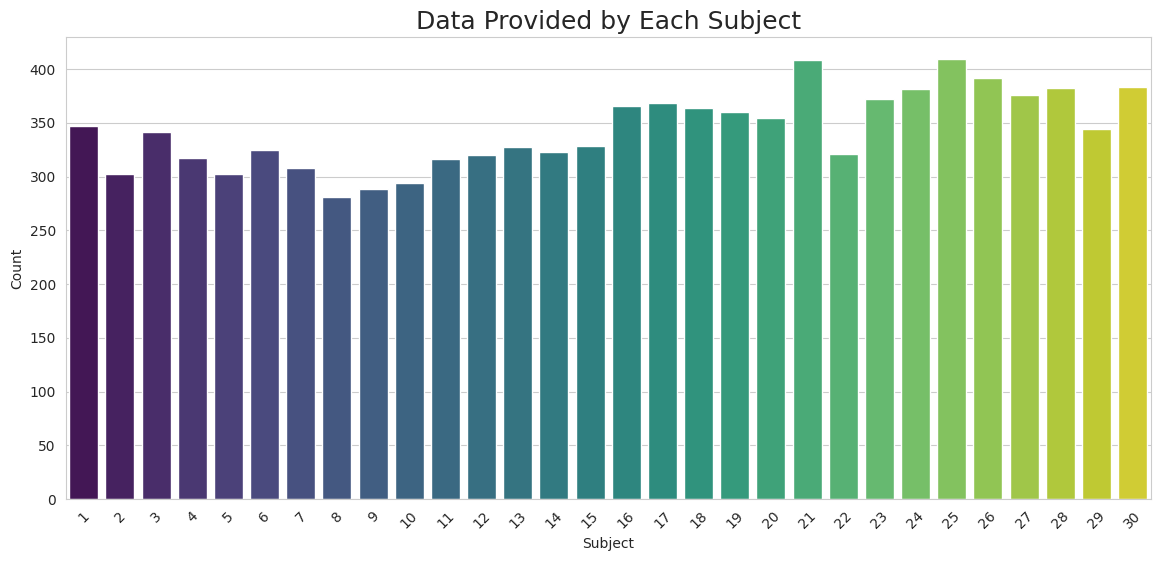

In [ ]:
# 1. Distribution of Readings per Subject
# Distribution of Readings per Subject: This plot shows the count of samples collected from each subject, verifying that the dataset has
#  a similar number of readings for each subject.

plt.figure(figsize=(14, 6))
plt.title('Data Provided by Each Subject', fontsize=18)
sns.countplot(x='Subject', data=data, palette="viridis")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<ipython-input-23-9e122d5bb108>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ActivityName', data=data, palette="coolwarm")


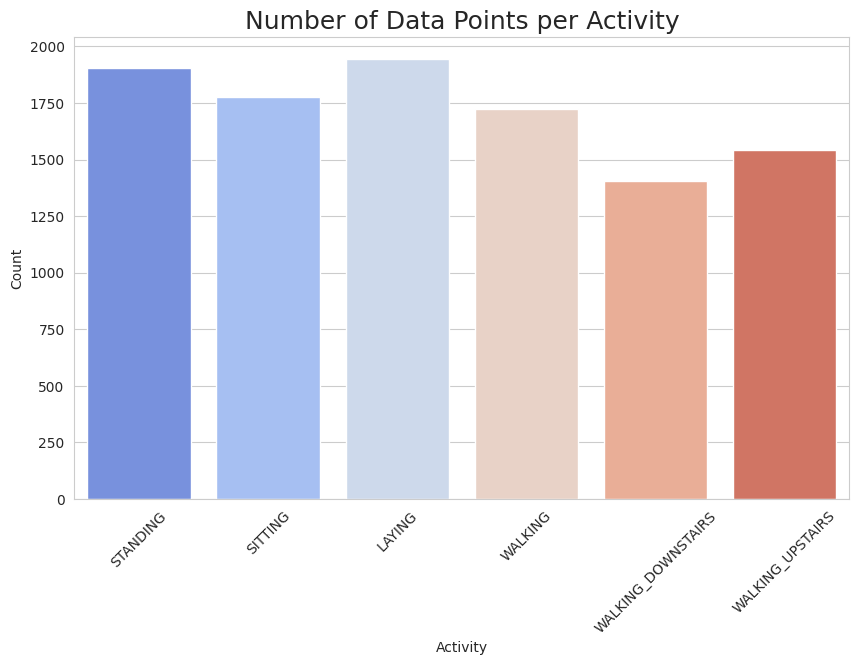

In [ ]:
# 2. Distribution of Activities in the Dataset
# Distribution of Activities: This plot provides a high-level view of the activity
# balance across the entire dataset, confirming that we have a well-balanced distribution of activity types.

plt.figure(figsize=(10, 6))
plt.title('Number of Data Points per Activity', fontsize=18)
sns.countplot(x='ActivityName', data=data, palette="coolwarm")
plt.xlabel("Activity")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

<ipython-input-24-4f1b58654f54>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Subject',  data=data, palette="Spectral")


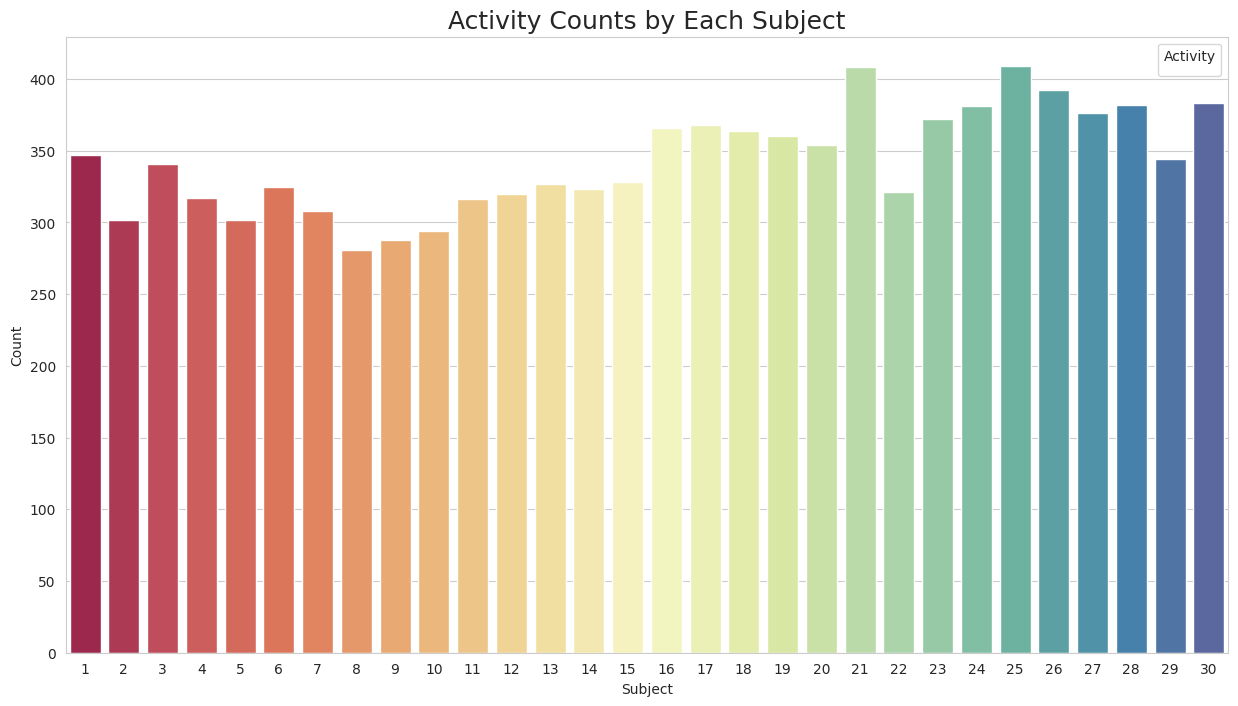

In [ ]:
# 3. Activity Counts by Subject
# Activity Counts by Subject: This plot allows us to see if each subject participated in
#  each activity and to what extent. It's useful for ensuring that all subjects have a diverse range of activities.

plt.figure(figsize=(15, 8))
plt.title('Activity Counts by Each Subject', fontsize=18)
sns.countplot(x='Subject',  data=data, palette="Spectral")
plt.xlabel("Subject")
plt.ylabel("Count")
plt.legend(loc='upper right', title='Activity')
# plt.xticks(rotation=45)
plt.show()

# **Model**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Signals from the dataset
SIGNALS = [
    "body_acc_x", "body_acc_y", "body_acc_z",
    "body_gyro_x", "body_gyro_y", "body_gyro_z",
    "total_acc_x", "total_acc_y", "total_acc_z"
]
DATADIR = 'UCI HAR Dataset'

In [ ]:
DATADIR = '/content/drive/MyDrive/UCI_HAR_Project/UCI HAR Dataset'

# Helper functions for loading data
def _read_csv(filename):
    return pd.read_csv(filename, sep='\s+', header=None)

def load_signals(subset):
    signals_data = []
    for signal in SIGNALS:
        filename = f'{DATADIR}/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(_read_csv(filename).to_numpy())
    return np.transpose(signals_data, (1, 2, 0))

def load_y(subset):
    filename = f'{DATADIR}/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    return pd.get_dummies(y).to_numpy()

def load_data():
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')
    return X_train, X_test, y_train, y_test

# Load data
X_train, X_test, Y_train, Y_test = load_data()
n_steps, n_length, input_dim = 4, 32, 9  # Reshape parameters

In [ ]:
# Reshape data to match CNN-LSTM input requirements
X_train = X_train.reshape((X_train.shape[0], n_steps, n_length, input_dim))
X_test = X_test.reshape((X_test.shape[0], n_steps, n_length, input_dim))


In [ ]:
# CNN-LSTM model architecture
model = Sequential()
# CNN layers for feature extraction
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, input_dim)))
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
# LSTM layer for sequence learning
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))  # Output layer
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, None, 30, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, None, 28, 64)        │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, None, 14, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, None, 896)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 100)                 │         398,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          10,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,650 (1.62 MB)

 Trainable params: 423,650 (1.62 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training parameters
epochs, batch_size = 30, 32

# Training
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)


Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.6183 - loss: 0.8683 - val_accuracy: 0.8622 - val_loss: 0.4585
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9256 - loss: 0.1984 - val_accuracy: 0.8765 - val_loss: 0.3882
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9495 - loss: 0.1298 - val_accuracy: 0.8761 - val_loss: 0.4694
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9514 - loss: 0.1266 - val_accuracy: 0.8744 - val_loss: 0.4869
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.9457 - loss: 0.1285 - val_accuracy: 0.8921 - val_loss: 0.4017
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 22s 61ms/step - accuracy: 0.9523 - loss: 0.1136 - val_accuracy: 0.8911 - val_loss: 0.4495
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9527 - loss: 0.1182 - val_accuracy: 0.8999 - val_loss: 0.3121
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9477 - loss: 0.1145 - 

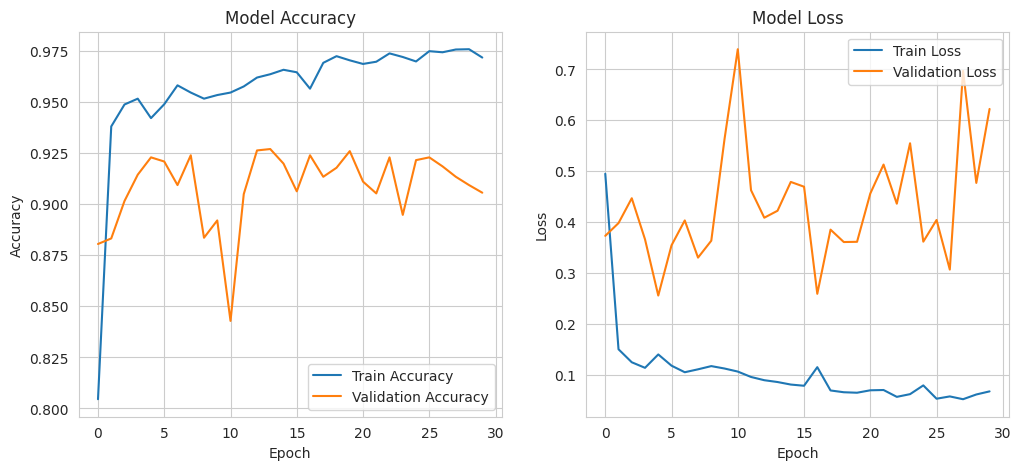

In [ ]:
# Plot training and validation accuracy/loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.9233
Test Loss: 0.4607


93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step


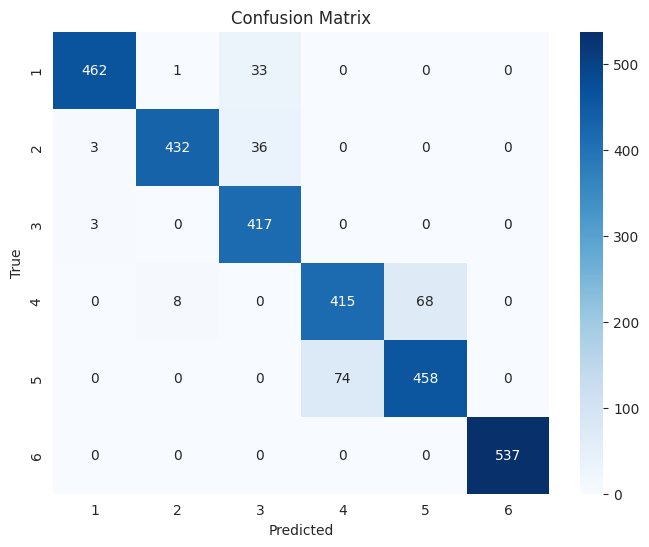

In [ ]:
# Confusion matrix
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test, axis=1)
conf_matrix = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Assuming Y_test is a 1D array of class labels
if Y_test.ndim == 1:
    num_classes = len(np.unique(Y_test))
    Y_test = np.eye(num_classes)[Y_test]

# Assuming Y_pred is also a 1D array of predicted class labels
if Y_pred.ndim == 1:
    num_classes = len(np.unique(Y_pred))
    Y_pred = np.eye(num_classes)[Y_pred]


In [ ]:
# Generate the classification report
from sklearn.metrics import classification_report, accuracy_score
report = classification_report(Y_test.argmax(axis=1), Y_pred.argmax(axis=1), target_names=activity_labels)
print(report)


              precision    recall  f1-score   support

    Activity       0.99      0.93      0.96       496
       Label       0.98      0.92      0.95       471

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.93      0.92      0.92      2947



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Check shapes
print("Y_test shape:", Y_test.shape)
print("Y_pred shape:", Y_pred.shape)


# Calculate accuracy
Y_pred_classes = Y_pred.argmax(axis=1)
Y_test_classes = Y_test.argmax(axis=1)
accuracy = accuracy_score(Y_test_classes, Y_pred_classes)

# Print accuracy in percentage
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Y_test shape: (2947, 6)
Y_pred shape: (2947, 6)
Model Accuracy: 92.33%


# **Testing**

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Assuming the activity labels DataFrame has already been defined
# activity_labels = pd.DataFrame({
#     'Activity': [1, 2, 3, 4, 5, 6],
#     'Label': ["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"]
# })

# Assuming X_train, X_test, Y_train, Y_test are already loaded
# Assuming `model` has been defined and trained

# Take a subset of X_test and y_test as new test data
X_new_test = X_test[:10]  # Adjust the number of samples as needed
y_new_test_actual = Y_test[:10]

# Predict activity labels for the new test data
Y_new_pred = model.predict(X_new_test)

# Convert predictions and actual labels to class indices
Y_new_pred_classes = Y_new_pred.argmax(axis=1)
y_new_test_actual_classes = y_new_test_actual.argmax(axis=1)

# Convert the 'Label' column in activity_labels DataFrame to a list
activity_labels_list = activity_labels['Label'].tolist()

# Ensure the indices in Y_new_pred_classes map to valid entries in activity_labels_list
max_index = len(activity_labels_list) - 1
predicted_activity_labels = [
    activity_labels_list[i] if i <= max_index else "Unknown" for i in Y_new_pred_classes
]
actual_activity_labels = [
    activity_labels_list[i] if i <= max_index else "Unknown" for i in y_new_test_actual_classes
]

# Create a DataFrame to display actual vs predicted labels
results_df = pd.DataFrame({
    'Sample': range(1, len(Y_new_pred_classes) + 1),
    'Actual Activity': actual_activity_labels,
    'Predicted Activity': predicted_activity_labels
})

# Display the table
print("Comparison of Actual and Predicted Activity Labels:")
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Comparison of Actual and Predicted Activity Labels:
   Sample Actual Activity Predicted Activity
0       1        STANDING           STANDING
1       2        STANDING           STANDING
2       3        STANDING           STANDING
3       4        STANDING           STANDING
4       5        STANDING           STANDING
5       6        STANDING           STANDING
6       7        STANDING           STANDING
7       8        STANDING           STANDING
8       9        STANDING           STANDING
9      10        STANDING           STANDING


In [ ]:
# Get unique classes from the Y_test data
unique_classes = np.unique(Y_test.argmax(axis=1))

# Initialize lists for new test data
X_new_test = []
y_new_test_actual = []

# For each unique class, find an example and add it to the new test set
for class_index in unique_classes:
    # Get indices of samples with the current class
    class_indices = np.where(Y_test.argmax(axis=1) == class_index)[0]

    # Take the first example from each activity class
    sample_index = class_indices[0]
    X_new_test.append(X_test[sample_index])
    y_new_test_actual.append(Y_test[sample_index])

# Convert to numpy arrays
X_new_test = np.array(X_new_test)
y_new_test_actual = np.array(y_new_test_actual)

# Predict activity labels for the new test data
Y_new_pred = model.predict(X_new_test)

# Convert predictions and actual labels to class indices
Y_new_pred_classes = Y_new_pred.argmax(axis=1)
y_new_test_actual_classes = y_new_test_actual.argmax(axis=1)

# Convert the 'Label' column in activity_labels DataFrame to a list
activity_labels_list = activity_labels['Label'].tolist()

# Ensure the indices in Y_new_pred_classes map to valid entries in activity_labels_list
max_index = len(activity_labels_list) - 1
predicted_activity_labels = [
    activity_labels_list[i] if i <= max_index else "Unknown" for i in Y_new_pred_classes
]
actual_activity_labels = [
    activity_labels_list[i] if i <= max_index else "Unknown" for i in y_new_test_actual_classes
]

# Create a DataFrame to display actual vs predicted labels
results_df = pd.DataFrame({
    'Sample': range(1, len(Y_new_pred_classes) + 1),
    'Actual Activity': actual_activity_labels,
    'Predicted Activity': predicted_activity_labels
})

# Display the table
print("Comparison of Actual and Predicted Activity Labels for Diverse Activities:")
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Comparison of Actual and Predicted Activity Labels for Diverse Activities:
   Sample     Actual Activity  Predicted Activity
0       1             WALKING             WALKING
1       2    WALKING_UPSTAIRS    WALKING_UPSTAIRS
2       3  WALKING_DOWNSTAIRS  WALKING_DOWNSTAIRS
3       4             SITTING            STANDING
4       5            STANDING            STANDING
5       6              LAYING              LAYING


## **LSTM to CNN model**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Assume the processed X_train, X_test, Y_train, Y_test are already loaded from previous preprocessing steps

# Define reshaping parameters
n_steps, n_length, input_dim = 4, 32, 9  # Adjust these as per data

# Reshape data to fit LSTM input (n_steps * n_length should match the LSTM sequence length)
X_train = X_train.reshape((X_train.shape[0], n_steps * n_length, input_dim))
X_test = X_test.reshape((X_test.shape[0], n_steps * n_length, input_dim))

# LSTM-CNN Model
model = Sequential()

# LSTM layer for sequence learning
model.add(LSTM(100, input_shape=(n_steps * n_length, input_dim), return_sequences=True))
model.add(Dropout(0.5))

# Reshape output to fit Conv1D input requirements
model.add(Reshape((n_steps * n_length, 100)))  # Reshape LSTM output to (timesteps, features)

# Convolution layers for feature extraction
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

# Dense layers for final classification
model.add(Dense(100, activation='relu'))
model.add(Dense(Y_train.shape[1], activation='softmax'))

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 128, 100)            │          44,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 128, 100)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 126, 64)             │          19,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 124, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 3968)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         396,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 473,122 (1.80 MB)

 Trainable params: 473,122 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# Set training parameters
epochs, batch_size = 30, 32

# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, batch_size=batch_size)

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

Epoch 1/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 158ms/step - accuracy: 0.6633 - loss: 0.8215 - val_accuracy: 0.8806 - val_loss: 0.3729
Epoch 2/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 42s 165ms/step - accuracy: 0.9373 - loss: 0.1521 - val_accuracy: 0.8833 - val_loss: 0.3980
Epoch 3/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.9516 - loss: 0.1261 - val_accuracy: 0.9016 - val_loss: 0.4469
Epoch 4/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 43s 148ms/step - accuracy: 0.9526 - loss: 0.1112 - val_accuracy: 0.9145 - val_loss: 0.3660
Epoch 5/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 34s 148ms/step - accuracy: 0.9402 - loss: 0.1533 - val_accuracy: 0.9230 - val_loss: 0.2556
Epoch 6/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 41s 150ms/step - accuracy: 0.9472 - loss: 0.1230 - val_accuracy: 0.9209 - val_loss: 0.3543
Epoch 7/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - accuracy: 0.9609 - loss: 0.0985 - val_accuracy: 0.9094 - val_loss: 0.4032
Epoch 8/30
230/230 ━━━━━━━━━━━━━━━━━━━━ 40s 138ms/step - accuracy: 0.9533 - loss: 0

<Figure size 1200x500 with 0 Axes>

<Figure size 1200x500 with 0 Axes>

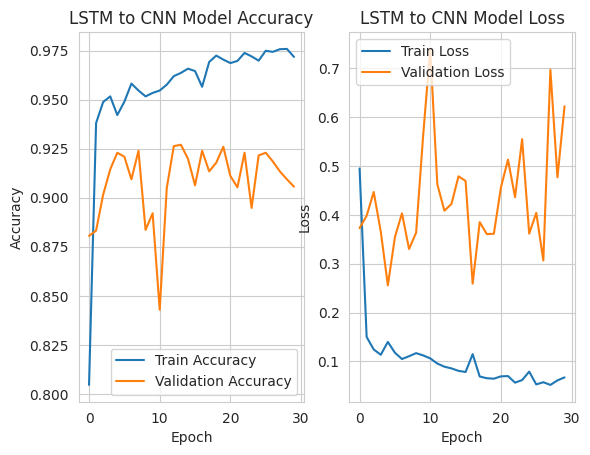

In [ ]:

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM to CNN Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM to CNN Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()




In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"Test Accuracy of LSTM to CNN Model: {test_accuracy:.4f}")
print(f"Test Loss of LSTM to CNN Model: {test_loss:.4f}")



Test Accuracy of LSTM to CNN Model: 0.9057
Test Loss of LSTM to CNN Model: 0.6225


93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step


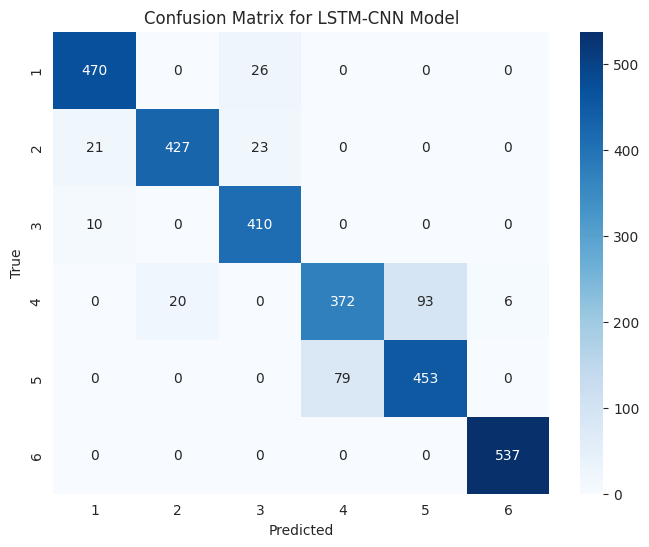

Classification Report for LSTM-CNN Model:
                    precision    recall  f1-score   support

           WALKING       0.94      0.95      0.94       496
  WALKING_UPSTAIRS       0.96      0.91      0.93       471
WALKING_DOWNSTAIRS       0.89      0.98      0.93       420
           SITTING       0.82      0.76      0.79       491
          STANDING       0.83      0.85      0.84       532
            LAYING       0.99      1.00      0.99       537

          accuracy                           0.91      2947
         macro avg       0.91      0.91      0.91      2947
      weighted avg       0.91      0.91      0.90      2947



In [ ]:
# Predictions and Confusion Matrix for LSTM-CNN Model
Y_pred = np.argmax(model.predict(X_test), axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(1, 7), yticklabels=np.arange(1, 7))
plt.title('Confusion Matrix for LSTM-CNN Model')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Classification Report

from sklearn.metrics import classification_report

# Assuming activity_labels is read from a CSV file or defined earlier
# If it's not a DataFrame, convert it:
# Example: activity_labels = pd.read_csv('path_to_activity_labels.csv')
# Ensure it has a column 'Label' for this to work correctly.

# Create a DataFrame from the activity_labels list if necessary
if isinstance(activity_labels, list):
    activity_labels = pd.DataFrame(activity_labels, columns=['Label'])


print("Classification Report for LSTM-CNN Model:")
print(classification_report(Y_true, Y_pred, target_names=activity_labels['Label'].tolist()))



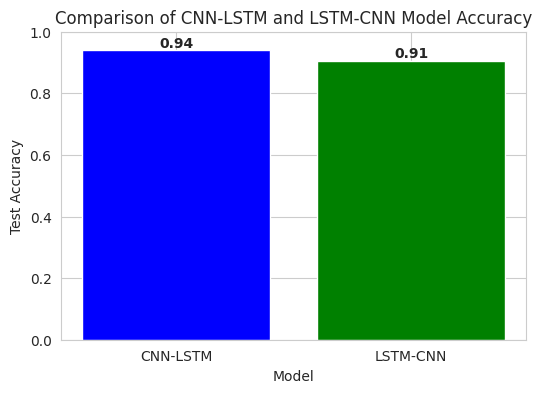

In [ ]:


# Model Comparison with CNN-LSTM
# Assuming the test accuracy for CNN-LSTM model is already computed and stored in `cnn_lstm_test_accuracy`

# Plotting the comparison between CNN-LSTM and LSTM-CNN
cnn_lstm_test_accuracy = 0.94  # Placeholder, replace with actual accuracy from the CNN-LSTM model

plt.figure(figsize=(6, 4))
models = ['CNN-LSTM', 'LSTM-CNN']
accuracies = [cnn_lstm_test_accuracy, test_accuracy]
plt.bar(models, accuracies, color=['blue', 'green'])
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Comparison of CNN-LSTM and LSTM-CNN Model Accuracy')
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Get unique classes from the Y_test data
unique_classes = np.unique(Y_test.argmax(axis=1))

# Initialize lists for new test data
X_new_test = []
y_new_test_actual = []

# For each unique class, find an example and add it to the new test set
for class_index in unique_classes:
    # Get indices of samples with the current class
    class_indices = np.where(Y_test.argmax(axis=1) == class_index)[0]

    # Take the first example from each activity class
    sample_index = class_indices[0]
    X_new_test.append(X_test[sample_index])
    y_new_test_actual.append(Y_test[sample_index])

# Convert to numpy arrays
X_new_test = np.array(X_new_test)
y_new_test_actual = np.array(y_new_test_actual)

# Predict activity labels for the new test data
Y_new_pred = model.predict(X_new_test)

# Convert predictions and actual labels to class indices
Y_new_pred_classes = Y_new_pred.argmax(axis=1)
y_new_test_actual_classes = y_new_test_actual.argmax(axis=1)


# Assuming activity_labels is read from a CSV file or defined earlier
# If it's not a DataFrame, convert it:
# Example: activity_labels = pd.read_csv('path_to_activity_labels.csv')
# Ensure it has a column 'Label' for this to work correctly.

# Create a DataFrame from the activity_labels list if necessary
if isinstance(activity_labels, list):
    activity_labels = pd.DataFrame(activity_labels, columns=['Label'])


# Convert the 'Label' column in activity_labels DataFrame to a list
activity_labels_list = activity_labels['Label'].tolist()

# Map indices in Y_new_pred_classes and y_new_test_actual_classes to activity labels
predicted_activity_labels = [activity_labels_list[i] for i in Y_new_pred_classes]
actual_activity_labels = [activity_labels_list[i] for i in y_new_test_actual_classes]

# Create a DataFrame to display actual vs predicted labels
results_df = pd.DataFrame({
    'Sample': range(1, len(Y_new_pred_classes) + 1),
    'Actual Activity': actual_activity_labels,
    'Predicted Activity': predicted_activity_labels
})

# Display the table
print("Comparison of Actual and Predicted Activity Labels for Diverse Activities:")
print(results_df)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Comparison of Actual and Predicted Activity Labels for Diverse Activities:
   Sample     Actual Activity  Predicted Activity
0       1             WALKING             WALKING
1       2    WALKING_UPSTAIRS    WALKING_UPSTAIRS
2       3  WALKING_DOWNSTAIRS  WALKING_DOWNSTAIRS
3       4             SITTING            STANDING
4       5            STANDING            STANDING
5       6              LAYING              LAYING


In [ ]:
from sklearn.metrics import accuracy_score

# Assuming you have your true labels and predictions
Y_true = Y_test.argmax(axis=1)  # Convert one-hot encoded labels to class indices
Y_pred = model.predict(X_test)  # Use your LSTM-CNN model here
Y_pred_classes = Y_pred.argmax(axis=1)  # Get predicted class indices

# Calculate accuracy
accuracy_lstm_cnn = accuracy_score(Y_true, Y_pred_classes)

# Print accuracy in percentage format
print(f"Accuracy of LSTM-CNN Model: {accuracy_lstm_cnn * 100:.2f}%")


93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step
Accuracy of LSTM-CNN Model: 90.57%
